# Crossover: ordered, LocalSearch: None

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [2]:
file_path = "City_Dataset/att48_name.txt"

with open(file_path, "r") as file:
    lines = file.readlines()

nameList = [line.strip() for line in lines]
nameList

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia']

In [3]:
df_data = pd.read_csv("City_Dataset/att48_coordinates.csv", header=None, names=['X', 'Y'])
df_data

,X,Y
0,6734,1453
1,2233,10
2,5530,1424
3,401,841
4,3082,1644
5,7608,4458
6,7573,3716
7,7265,1268
8,6898,1885
9,1112,2049


In [4]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [5]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [6]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [7]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [8]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [9]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [10]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Ordered

In [11]:
def breed(parent1, parent2):
    child = [None] * len(parent1)
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        child[i] = parent1[i]

    not_added = [item for item in parent2 if item not in child]
    idx = 0
    for i in range(len(child)):
        if child[i] is None:
            child[i] = not_added[idx]
            idx += 1

    return child


In [14]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [15]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [16]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop


In [17]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [18]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

In [20]:
cityList = []

for i in range(len(df_data)):
    X, Y = df_data.values[i]
    cityList.append(City(x=int(X), y=int(Y)))

cityList

[(6734,1453),
 (2233,10),
 (5530,1424),
 (401,841),
 (3082,1644),
 (7608,4458),
 (7573,3716),
 (7265,1268),
 (6898,1885),
 (1112,2049),
 (5468,2606),
 (5989,2873),
 (4706,2674),
 (4612,2035),
 (6347,2683),
 (6107,669),
 (7611,5184),
 (7462,3590),
 (7732,4723),
 (5900,3561),
 (4483,3369),
 (6101,1110),
 (5199,2182),
 (1633,2809),
 (4307,2322),
 (675,1006),
 (7555,4819),
 (7541,3981),
 (3177,756),
 (7352,4506),
 (7545,2801),
 (3245,3305),
 (6426,3173),
 (4608,1198),
 (23,2216),
 (7248,3779),
 (7762,4595),
 (7392,2244),
 (3484,2829),
 (6271,2135),
 (4985,140),
 (1916,1569),
 (7280,4899),
 (7509,3239),
 (10,2676),
 (6807,2993),
 (5185,3258),
 (3023,1942)]

## Plot the improvement

In [21]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    return bestRoute

Initial distance: 132644.63215754365
Final distance: 44543.41566225019


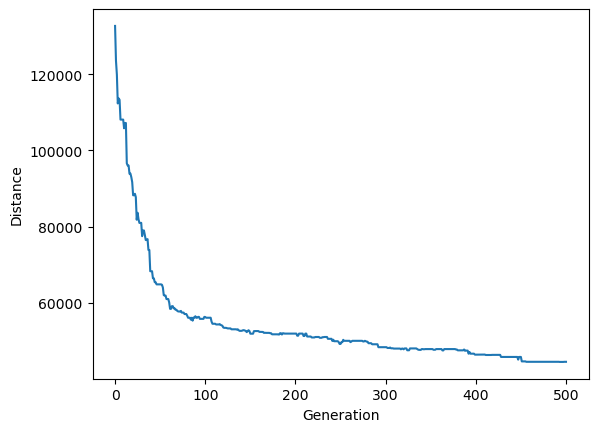

[(1633,2809),
 (10,2676),
 (23,2216),
 (1916,1569),
 (3177,756),
 (4608,1198),
 (5530,1424),
 (4612,2035),
 (4307,2322),
 (3484,2829),
 (3245,3305),
 (4483,3369),
 (5185,3258),
 (5900,3561),
 (5468,2606),
 (5199,2182),
 (4706,2674),
 (3082,1644),
 (3023,1942),
 (1112,2049),
 (675,1006),
 (401,841),
 (2233,10),
 (4985,140),
 (6107,669),
 (6101,1110),
 (6734,1453),
 (7265,1268),
 (6898,1885),
 (6271,2135),
 (6347,2683),
 (6426,3173),
 (6807,2993),
 (7509,3239),
 (7573,3716),
 (7541,3981),
 (7352,4506),
 (7608,4458),
 (7762,4595),
 (7732,4723),
 (7555,4819),
 (7611,5184),
 (7280,4899),
 (7248,3779),
 (7462,3590),
 (7545,2801),
 (7392,2244),
 (5989,2873)]

In [22]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [24]:
#Using For optimal 
file_path = "City_Dataset/att48_opttour.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

opt = [int(line.strip()) - 1 for line in lines]
optList = []

for i in range(len(opt)):
            optList.append([df_data.loc[opt[i], "X"], df_data.loc[opt[i], "Y"]])

result = pd.read_csv("City_Dataset/result_9.csv", header=None, names=['X', 'Y'])
same = 0

for i in range(len(optList)):
    if(optList[i][0] == result.loc[i, 'X'] and optList[i][1] == result.loc[i, 'Y']):
        same += 1
        print(f"{i} index same {optList[i], result.loc[i]}")
print('----------------------------------------------------------------------------')
print(f"{same} count")
print(same/(len(optList) + len(result) - same))

----------------------------------------------------------------------------
0 count
0.0
